In [1]:
import sys
sys.path.insert(0, './../Models')

from mlp_mixer import MLPMixer
from imagenet1k_dataloader import get_imagenet_loaders

import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
def convert_keys(state_dict, map_classifier, num_classes = 10):
    keys = state_dict.keys()
    new_keys = []
    new_state_dict = {}

    for key in keys:
        new_key = key.replace("/", ".")
        new_key = new_key.replace("MixerBlock_", "MixerBlock.")
        new_key = new_key.replace("channel_mixing.Dense_0", "channel_mixing.1.net.0")
        new_key = new_key.replace("channel_mixing.Dense_1", "channel_mixing.1.net.3")
        new_key = new_key.replace("token_mixing.Dense_0", "token_mixing.2.net.0")
        new_key = new_key.replace("token_mixing.Dense_1", "token_mixing.2.net.3")
        new_key = new_key.replace("LayerNorm_0", "token_mixing.0")
        new_key = new_key.replace("LayerNorm_1", "channel_mixing.0")
        new_key = new_key.replace("scale", "weight")
        new_key = new_key.replace("kernel", "weight")
        new_key = new_key.replace("stem", "stem.0")
        new_key = new_key.replace("head", "head.0")
        new_key = new_key.replace("pre_head.0_layer_norm", "pre_head_layer_norm")
        new_keys.append(new_key)
    
    if map_classifier:
        for (key, new_key) in zip(keys, new_keys): 
            new_state_dict[new_key] = torch.tensor(state_dict[key], dtype = torch.float32).T
    else:
        for (key, new_key) in zip(keys, new_keys):
            weights = torch.tensor(state_dict[key], dtype = torch.float32).T
            if "head." in new_key:
                k = np.random.randint(0, weights.shape[0], num_classes)
                # For bias
                if len(weights.shape) == 1:
                    weights = weights[k]
                # For weights
                else:
                    weights = weights[k, :]
            new_state_dict[new_key] = weights
    return new_state_dict

In [4]:
# B/16 architecture
net = MLPMixer(in_channels = 3,
               dim = 768,
               num_classes = 21843,
               patch_size = 16,
               image_size = 224,
               depth = 12,
               token_dim = 384,
               channel_dim = 3072).to(device)

google_weights = np.load("./../Weights/imagenet21k_Mixer-B_16.npz", allow_pickle = True)
new_weights = convert_keys(google_weights, map_classifier = True)

net.load_state_dict(new_weights, strict = False)

/tmp/ipykernel_314205/929378902.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  new_state_dict[new_key] = torch.tensor(state_dict[key], dtype = torch.float32).T


<All keys matched successfully>

In [5]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

net.head = Identity()
# net.pre_head_layer_norm = Identity()

In [6]:
imagenet1k_data_dir = "./../Data/imagenet1k/"
test_size = 0.1
batch_size = 32

train_loader, test_loader = get_imagenet_loaders(imagenet1k_data_dir, 
                                                 test_size = test_size, 
                                                 shuffle = True, 
                                                 batch_size = batch_size, 
                                                 device = device)

In [7]:
outputs = torch.Tensor()
labels = torch.Tensor()

tqdm_loader = tqdm(train_loader, desc = "Inference Train Data", position = 0, leave = True)
for dat in tqdm_loader:
    image, label = dat[0], dat[1].cpu().detach()
    output = net(image).cpu().detach()
    outputs = torch.cat((outputs, output), dim = 0)
    labels = torch.cat((labels, label), dim = 0)
    tqdm_loader.update(1)
tqdm_loader.close()

tqdm_loader = tqdm(test_loader, desc = "Inference Test Data", position = 0, leave = True)
for dat in tqdm_loader:
    image, label = dat[0], dat[1].cpu().detach()
    output = net(image).cpu().detach()
    outputs = torch.cat((outputs, output), dim = 0)
    labels = torch.cat((labels, label), dim = 0)
    tqdm_loader.update(1)

Inference Test Data: 100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


In [8]:
m = TSNE(n_components = 2, perplexity = 30, n_iter = 1000, learning_rate = 45)
features = m.fit_transform(outputs)

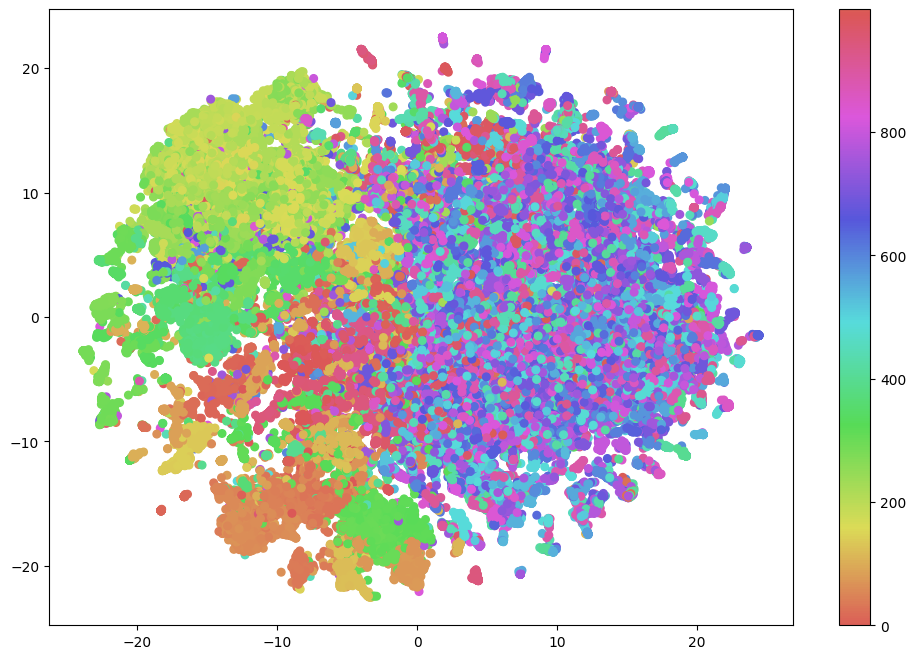

In [9]:
cmap = sns.hls_palette(as_cmap = True)
f, ax = plt.subplots(figsize = (12, 8))
points = ax.scatter(features[:, 0], features[:, 1], c = labels.numpy(), s = 30, cmap = cmap)
f.colorbar(points)
plt.savefig("./../Plots/Imagenet1k_imagenet21kweights_TSNE.png")
plt.show()